In [1]:
!pip install tensorflow numpy networkx

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install networkx

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import networkx as nx
import numpy as np

class NetworkEnvironment:
    def __init__(self, topology):
        self.topology = topology
        self.n_nodes = len(topology.nodes)
        self.reset()

    def reset(self):
        self.current_node = np.random.choice(self.n_nodes)
        self.done = False
        return self.current_node

    def step(self, action):
        next_node = action
        if next_node in self.topology[self.current_node]:
            reward = -self.topology[self.current_node][next_node].get('weight', 1)
            self.current_node = next_node
        else:
            reward = -10  # Penalty for invalid action
        if self.current_node == self.n_nodes - 1:  # Assuming the last node is the destination
            self.done = True
            reward = 100
        return self.current_node, reward, self.done

    def get_valid_actions(self):
        return list(self.topology[self.current_node].keys())


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import random

class DQNAgent:
    def __init__(self, n_nodes, n_actions, lr=0.001, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, batch_size=32, memory_size=2000):
        self.n_nodes = n_nodes
        self.n_actions = n_actions
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.memory = []
        self.memory_size = memory_size
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.n_nodes, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.n_actions, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.lr))
        return model

    def remember(self, state, action, reward, next_state, done):
        if len(self.memory) > self.memory_size:
            self.memory.pop(0)
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, valid_actions):
        if np.random.rand() <= self.epsilon:
            return random.choice(valid_actions)
        act_values = self.model.predict(state)
        return valid_actions[np.argmax(act_values[0][valid_actions])]

    def replay(self):
        minibatch = random.sample(self.memory, min(len(self.memory), self.batch_size))
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


In [ ]:
def preprocess_state(state, n_nodes):
    state_vec = np.zeros((1, n_nodes))
    state_vec[0][state] = 1
    return state_vec

def train_dqn_agent(env, agent, n_episodes=1000):
    for episode in range(n_episodes):
        state = env.reset()
        state = preprocess_state(state, env.n_nodes)
        total_reward = 0
        for time in range(500):
            valid_actions = env.get_valid_actions()
            action = agent.act(state, valid_actions)
            next_state, reward, done = env.step(action)
            next_state = preprocess_state(next_state, env.n_nodes)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                print(f"Episode: {episode+1}/{n_episodes}, Score: {total_reward}, Epsilon: {agent.epsilon:.2}")
                break
            agent.replay()

def test_dqn_agent(env, agent, start_node, destination_node):
    state = start_node
    state_vec = preprocess_state(state, env.n_nodes)
    path = [state]
    while state != destination_node:
        valid_actions = env.get_valid_actions()
        action = agent.act(state_vec, valid_actions)
        state, _, done = env.step(action)
        state_vec = preprocess_state(state, env.n_nodes)
        path.append(state)
        if done:
            break
    return path

# Define the network topology
topology = nx.Graph()
edges = [(0, 1, {'weight': 1}), (1, 2, {'weight': 2}), (2, 3, {'weight': 1}), (3, 4, {'weight': 2}), (0, 2, {'weight': 4}), (1, 3, {'weight': 5})]
topology.add_edges_from(edges)

# Initialize environment and agent
env = NetworkEnvironment(topology)
n_nodes = env.n_nodes
agent = DQNAgent(n_nodes=n_nodes, n_actions=n_nodes)

# Train the agent
train_dqn_agent(env, agent)

# Test the agent
start_node = 0
destination_node = n_nodes - 1
optimal_path = test_dqn_agent(env, agent, start_node, destination_node)
print("Optimal Path:", optimal_path)

In [1]:
import networkx as nx
import numpy as np

class NetworkEnvironment:
    def __init__(self, topology):
        self.topology = topology
        self.n_nodes = len(topology.nodes)
        self.reset()

    def reset(self):
        self.current_node = np.random.choice(self.n_nodes)
        self.done = False
        return self.current_node

    def step(self, action):
        next_node = action
        if next_node in self.topology[self.current_node]:
            reward = -self.topology[self.current_node][next_node].get('weight', 1)
            self.current_node = next_node
        else:
            reward = -10  # Penalty for invalid action
        if self.current_node == self.n_nodes - 1:  # Assuming the last node is the destination
            self.done = True
            reward = 100
        return self.current_node, reward, self.done

    def get_valid_actions(self):
        return list(self.topology[self.current_node].keys())


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import random

class DQNAgent:
    def __init__(self, n_nodes, n_actions, learning_rate=0.001, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, batch_size=32, memory_size=2000):
        self.n_nodes = n_nodes
        self.n_actions = n_actions
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.memory = []
        self.memory_size = memory_size
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_shape=(self.n_nodes,), activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.n_actions, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        if len(self.memory) > self.memory_size:
            self.memory.pop(0)
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, valid_actions):
        if np.random.rand() <= self.epsilon:
            return random.choice(valid_actions)
        act_values = self.model.predict(state)
        return valid_actions[np.argmax(act_values[0][valid_actions])]

    def replay(self):
        minibatch = random.sample(self.memory, min(len(self.memory), self.batch_size))
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


In [3]:
def preprocess_state(state, n_nodes):
    state_vec = np.zeros((1, n_nodes))
    state_vec[0][state] = 1
    return state_vec

def train_dqn_agent(env, agent, n_episodes=10):
    for episode in range(n_episodes):
        state = env.reset()
        state = preprocess_state(state, env.n_nodes)
        total_reward = 0
        for time in range(500):
            valid_actions = env.get_valid_actions()
            action = agent.act(state, valid_actions)
            next_state, reward, done = env.step(action)
            next_state = preprocess_state(next_state, env.n_nodes)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                print(f"Episode: {episode+1}/{n_episodes}, Score: {total_reward}, Epsilon: {agent.epsilon:.2}")
                break
            agent.replay()

def test_dqn_agent(env, agent, start_node, destination_node):
    state = start_node
    state_vec = preprocess_state(state, env.n_nodes)
    path = [state]
    while state != destination_node:
        valid_actions = env.get_valid_actions()
        action = agent.act(state_vec, valid_actions)
        state, _, done = env.step(action)
        state_vec = preprocess_state(state, env.n_nodes)
        path.append(state)
        if done:
            break
    return path

# Define the network topology
topology = nx.Graph()
edges = [(0, 1, {'weight': 1}), (1, 2, {'weight': 2}), (2, 3, {'weight': 1}), (3, 4, {'weight': 2}), (0, 2, {'weight': 4}), (1, 3, {'weight': 5})]
topology.add_edges_from(edges)

# Initialize environment and agent
env = NetworkEnvironment(topology)
n_nodes = env.n_nodes
agent = DQNAgent(n_nodes=n_nodes, n_actions=n_nodes)

# Train the agent
train_dqn_agent(env, agent)

# Test the agent
start_node = 0
destination_node = n_nodes - 1
optimal_path = test_dqn_agent(env, agent, start_node, destination_node)
print("Optimal Path:", optimal_path)


C:\Users\mohit\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━

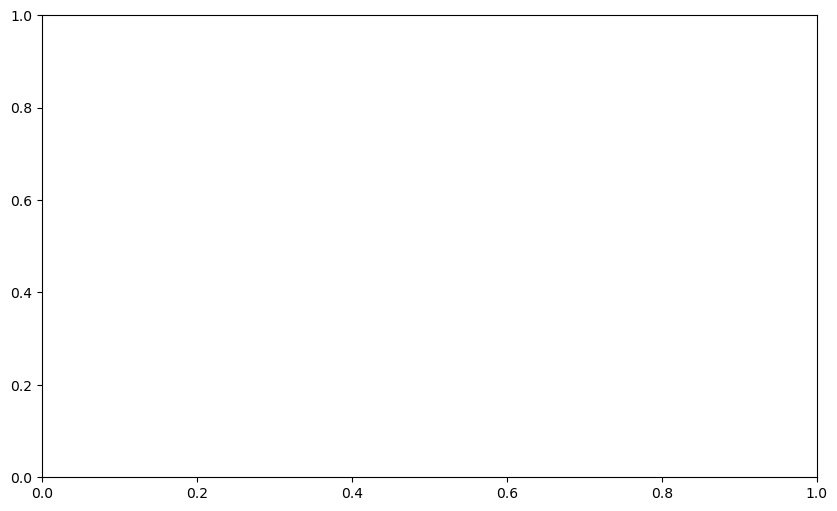

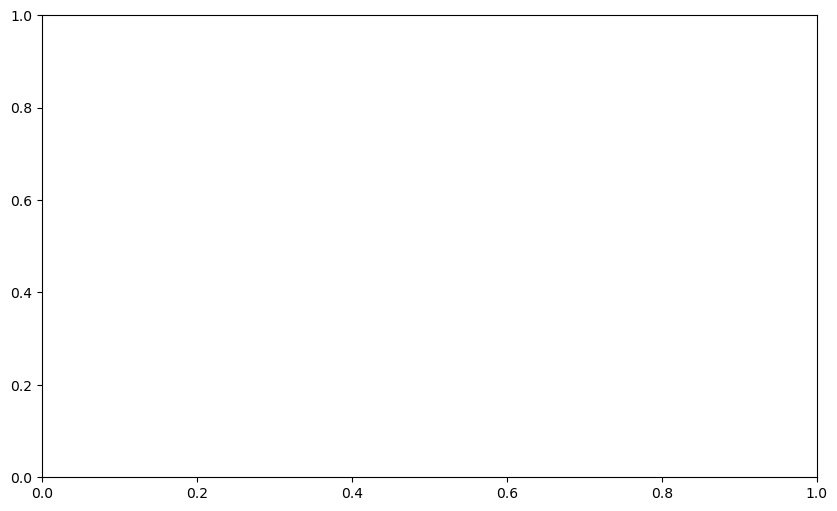

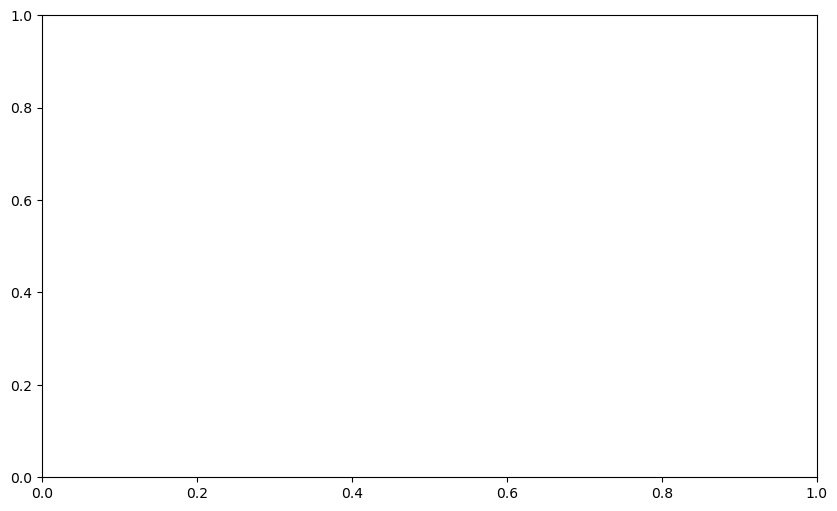

In [7]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Assuming NetworkEnvironment, DQNAgent, preprocess_state, train_dqn_agent classes/functions are defined

# Define the network topology
topology = nx.Graph()
edges = [(0, 1, {'weight': 1}), (1, 2, {'weight': 2}), (2, 3, {'weight': 1}), (3, 4, {'weight': 2}), (0, 2, {'weight': 4}), (1, 3, {'weight': 5})]
topology.add_edges_from(edges)

# Initialize environment and agent
env = NetworkEnvironment(topology)
n_nodes = env.n_nodes
agent = DQNAgent(n_nodes=n_nodes, n_actions=n_nodes)

# Train the agent (as defined previously)
#train_dqn_agent(env, agent)

# Animation function to visualize packet transfers
def animate_packet_transfer(path, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    pos = nx.spring_layout(env.topology)
    
    def update(frame):
        ax.clear()
        nx.draw(env.topology, pos, ax=ax, with_labels=True, node_size=700, node_color='lightblue')
        path_edges = list(zip(path[:frame+1], path[1:frame+2]))
        nx.draw_networkx_nodes(env.topology, pos, nodelist=path[:frame+1], node_color='green')
        nx.draw_networkx_edges(env.topology, pos, edgelist=path_edges, edge_color='red', width=2)
        ax.set_title(title)
    
    ani = FuncAnimation(fig, update, frames=len(path), interval=500, repeat=False)
    return ani

# Define the testing and animation function
def test_and_animate(agent, env, start_node, destination_node):
    state = start_node
    state_vec = preprocess_state(state, env.n_nodes)
    path = [state]
    while state != destination_node:
        valid_actions = env.get_valid_actions()
        action = agent.act(state_vec, valid_actions)
        state, _, done = env.step(action)
        state_vec = preprocess_state(state, env.n_nodes)
        path.append(state)
        if done:
            break
    ani = animate_packet_transfer(path, "Optimal Path")
    plt.show()
    return ani

# Test and animate the optimal path
animation = test_and_animate(agent, env, start_node=0, destination_node=4)

# Simulate path failure and recovery
def simulate_path_failure_and_recovery(env, agent, failed_edge, start_node, destination_node):
    # Remove the failed edge
    env.topology.remove_edge(*failed_edge)
    env.reset()
    # Test and animate after path failure
    animation_failure = test_and_animate(agent, env, start_node, destination_node)
    
    # Restore the failed edge and re-test
    env.topology.add_edge(*failed_edge, weight=1)
    env.reset()
    animation_recovery = test_and_animate(agent, env, start_node, destination_node)
    
    return animation_failure, animation_recovery

# Simulate path failure and recovery
failed_edge = (1, 2)
animation_failure, animation_recovery = simulate_path_failure_and_recovery(env, agent, failed_edge, start_node=0, destination_node=4)
